In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
# from TSB_AD.models.distance import Fourier
# from TSB_AD.models.feature import Window
from util.TSB_AD.metrics import metricor
from util.TSB_AD.slidingWindows import find_length #,plotFig, printResult
from sklearn.preprocessing import MinMaxScaler
import os
import stumpy
from util.TranAD_base import *
# from util.util_normal import plotFigKL, find_length, getResult, plotFigBeta
from util.util_overlap import *
from util.load_data import get_data, list_chunk, add_drift

from scipy.stats import entropy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, distance
from util.TSB_AD.models.norma import NORMA

from tqdm.notebook import tqdm
# from TSB_AD.utils.metrics import metricor
# import matplotlib.patches as mpatches 

# from scipy.signal import argrelextrema
# from statsmodels.tsa.stattools import acf

In [4]:
def test_norma(x_test, label_test, normalize, pattern_len, init_NMs, init_weights, name):
    score, d_s = compute_score(x_test, pattern_len, init_NMs, init_weights, normalize)
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    score = np.array([score[0]]*((pattern_len-1)//2) + list(score) + [score[-1]]*((pattern_len-1)//2))
    # plt.rc('font', size=10)
    # plt.rc('axes', labelsize=10)
    df_result = plotFig(x_test, label_test, score, pattern_len, fileName=name, modelName='NORMA-ON') #, plotRange=[1775,2200]
    # df_result = getResult(x_test, label_test, score, pattern_len, fileName=name, modelName='NORMA-ON', ADAD=False) #, plotRange=[1775,2200]
    return df_result


In [5]:

d2 = pd.read_csv('./data/benchmark/ECG/MBA_ECG805_data.out', header=None).to_numpy()

max_len = 20000
data = d2[:max_len,0].astype(float)
label = d2[:max_len,1]

x_test = data
label_test = label
label_test_cd = np.zeros(len(label_test))
normalize=True
# x_test = data
# label_test = label
plt.rc('font', size=30)
plt.rc('axes', labelsize=30)
slidingWindow = find_length(x_test)

  0%|          | 0/19208 [00:00<?, ?it/s]

        auc  precision    recall         f   Rrecall  ExistenceReward  \
0  0.985928   0.422752  0.970353  0.588927  0.850448              1.0   

   OverlapReward  Rprecision        Rf  precision_at_k  
0        0.81306    0.095519  0.171748        0.970353  


/Users/jongjunPark/Research-timeSeries/Adaptive-ADD-main/util/util_overlap.py:307: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(L, index=df.columns), ignore_index=True)


,auc,precision,recall,f,Rrecall,ExistenceReward,OverlapReward,Rprecision,Rf,precision_at_k
0,0.985928,0.422752,0.970353,0.588927,0.850448,1.0,0.81306,0.095519,0.171748,0.970353


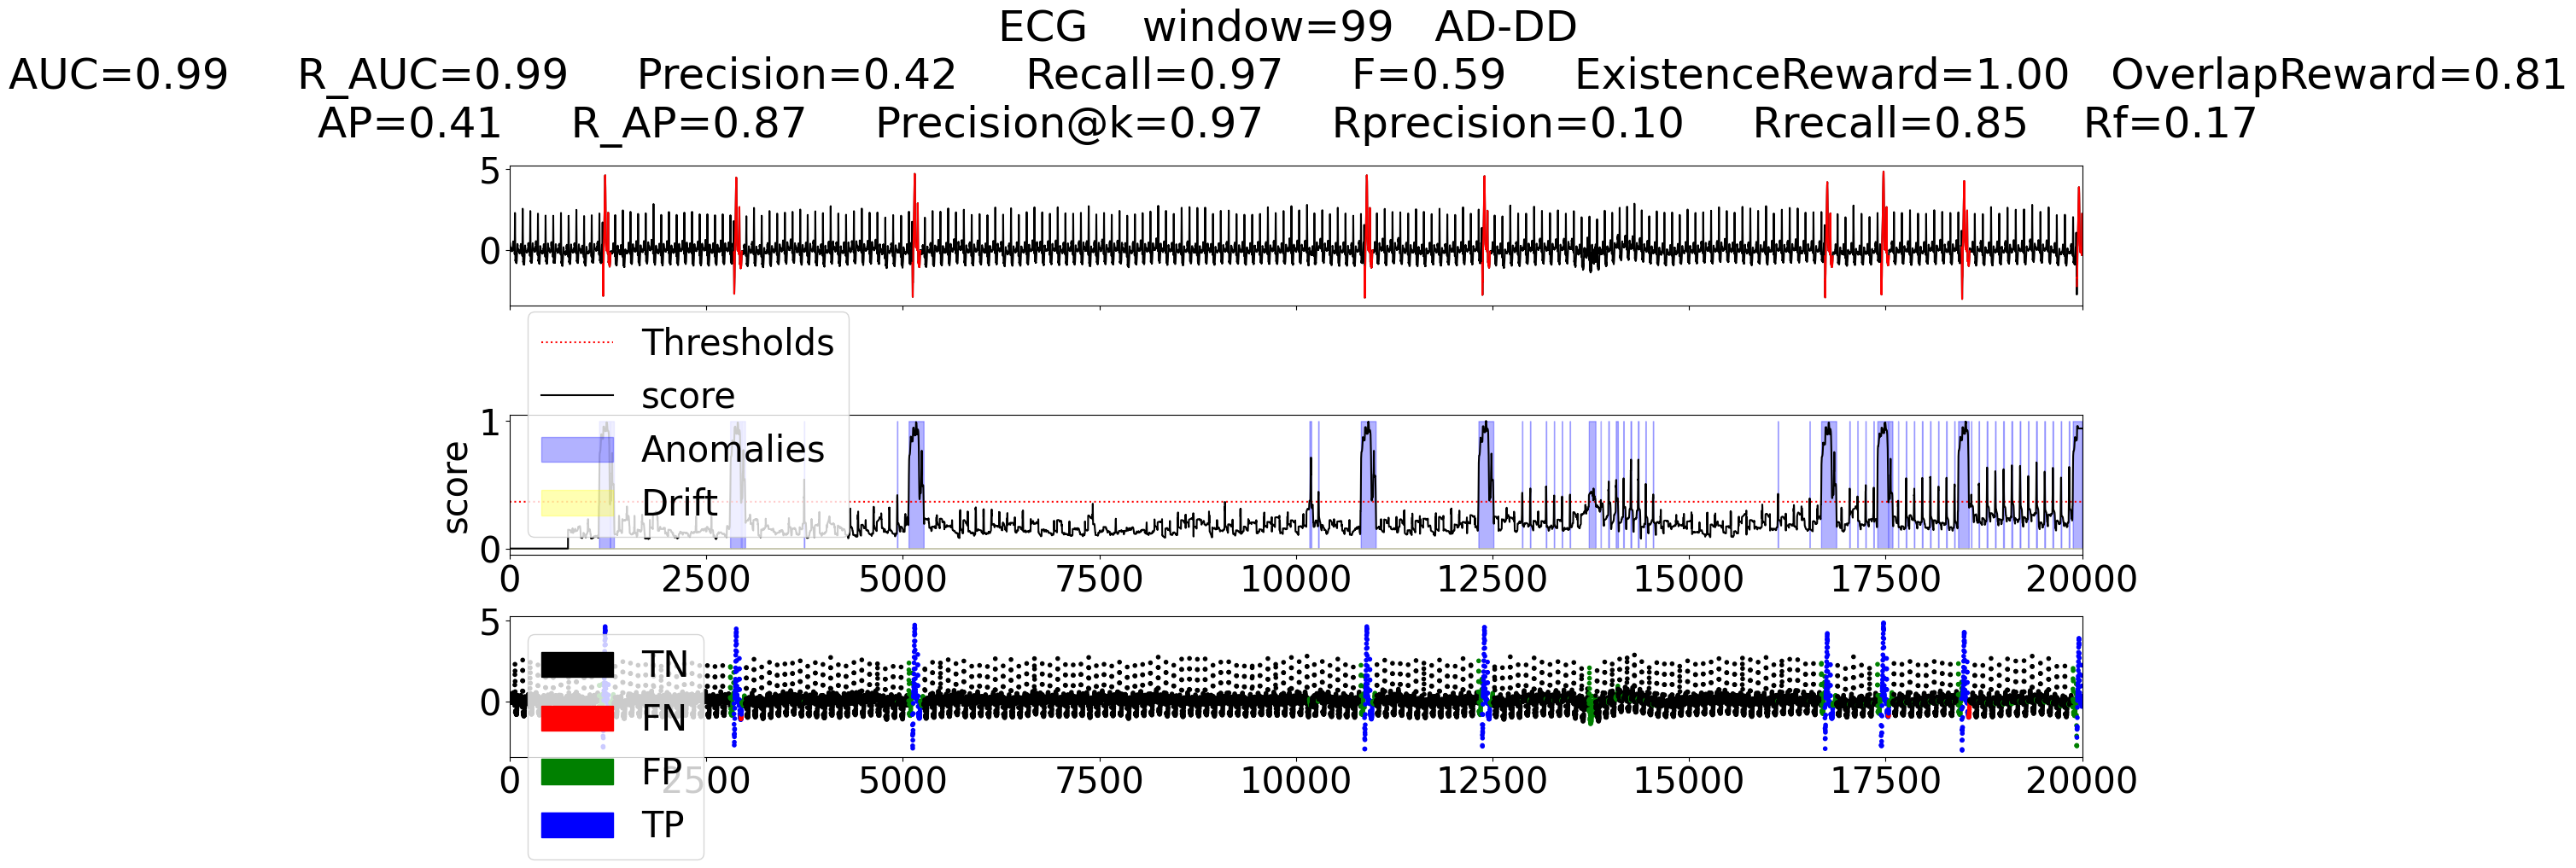

In [6]:
from util.TSB_AD.models.aadd import ADDD
clf_addd = ADDD(pattern_length=slidingWindow, size_L=7, normalize=normalize)
clf_addd.fit(x_test, online=True)
score1 = clf_addd.s_score
score2 = clf_addd.s2_score
plotFigKL(x_test[:len(score1)], label_test[:len(score1)], label_test_cd[:len(score2)], score2, score1, clf_addd.ths, slidingWindow, 'ECG', 'AD-DD', plotRange=None, y_pred=None, ADAD=False)    


0-->5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->[STOP]: score length 20000
        auc  precision    recall         f   Rrecall  ExistenceReward  \
0  0.998617   0.788915  0.762828  0.775652  0.817797              1.0   

   OverlapReward  Rprecision        Rf  precision_at_k  
0       0.772246    0.810214  0.813988        0.762828  


/Users/jongjunPark/Research-timeSeries/AAD-CD/util/util_overlap.py:438: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(L, index=df.columns), ignore_index=True)


,auc,precision,recall,f,Rrecall,ExistenceReward,OverlapReward,Rprecision,Rf,precision_at_k
0,0.998617,0.788915,0.762828,0.775652,0.817797,1.0,0.772246,0.810214,0.813988,0.762828


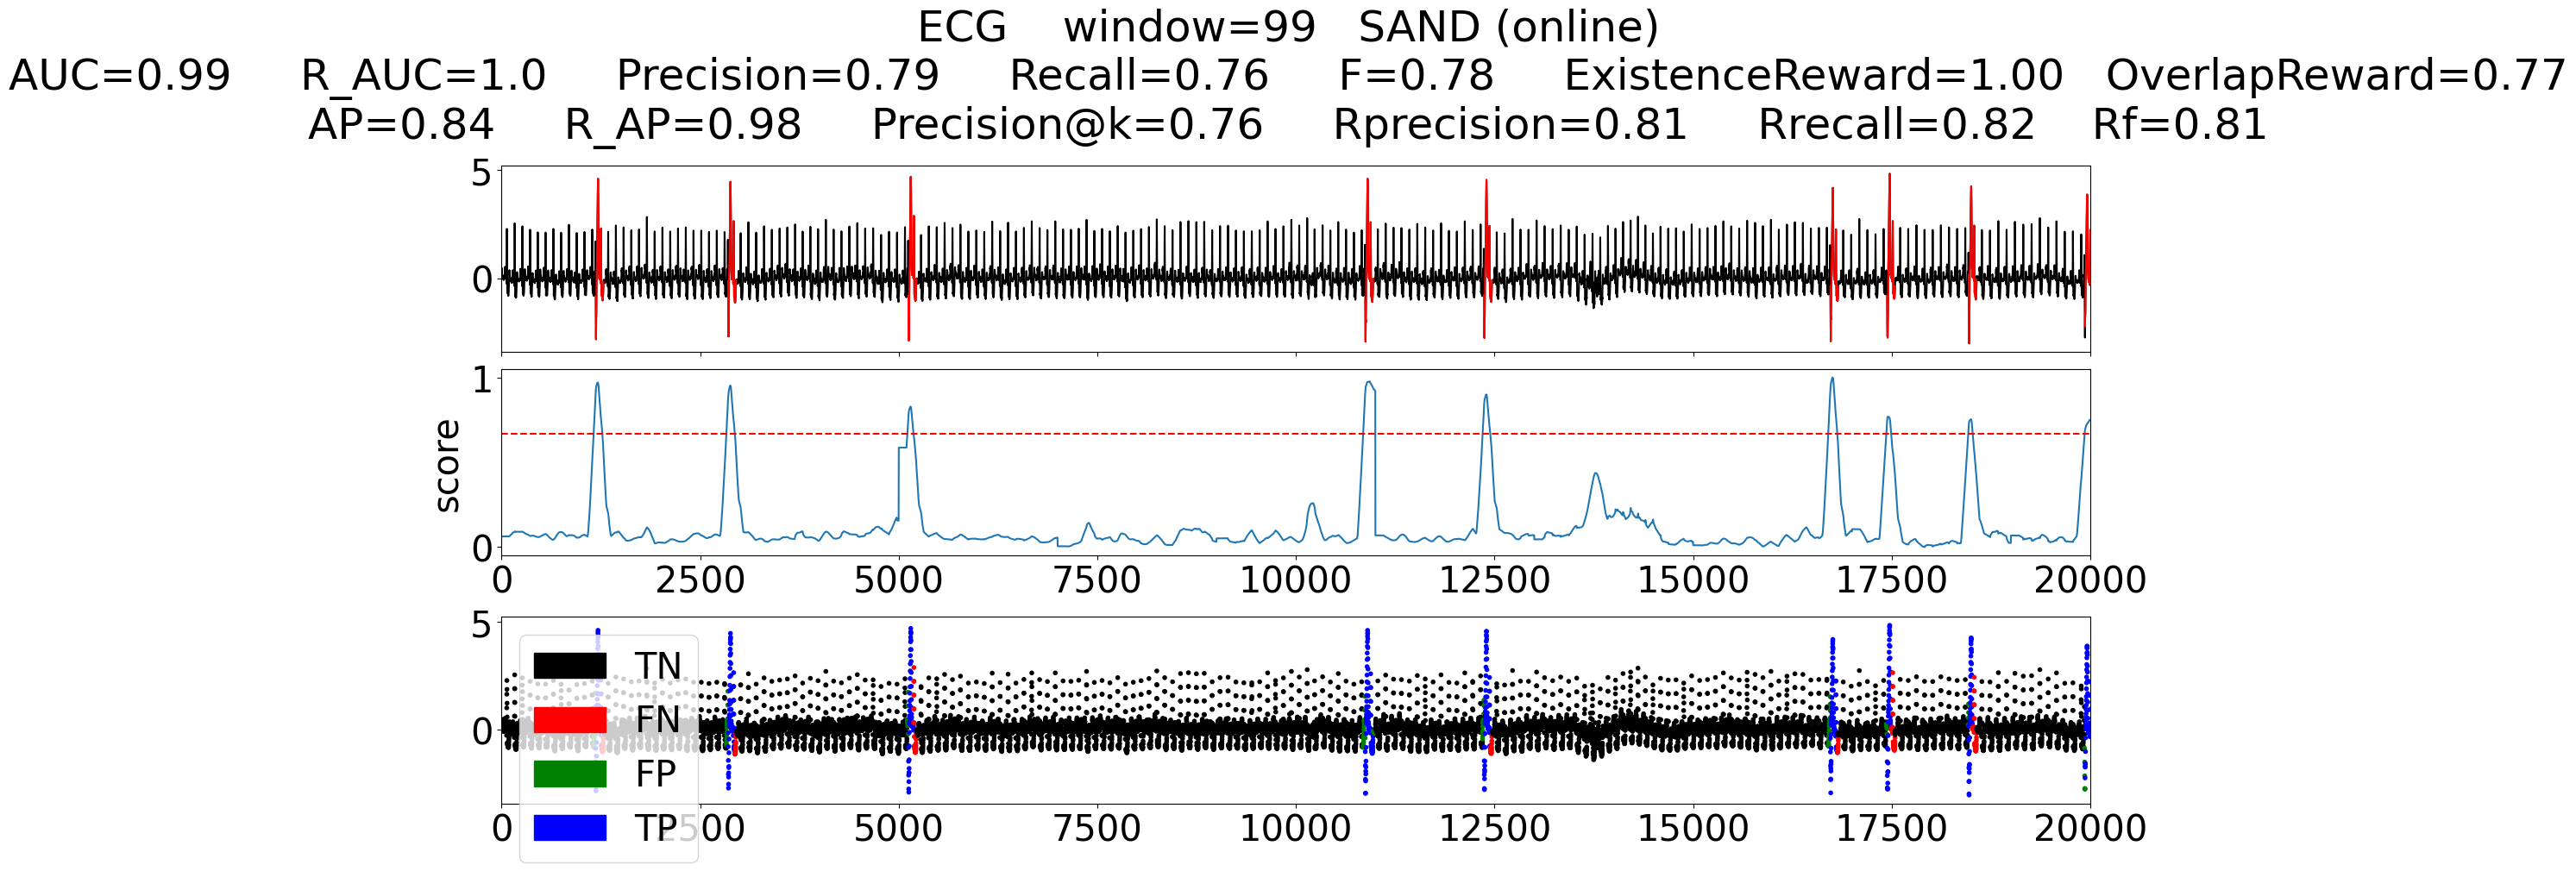

In [13]:
from util.TSB_AD.models.sand import SAND
modelName='SAND (online)'
scores = []
slabels = []
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
clf.fit(x,online=True,alpha=0.5,init_length=5000,batch_size=2000,verbose=True,overlaping_rate=int(4*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
# plotFig(data, label, score, slidingWindow, fileName='file', modelName=modelName) #, plotRange=[1775,2200]
scores.append(score[:len(x_test)])
slabels.append('SAND (online)\nAnomaly Score')
scores = scores[0]
plotFig(x[:len(scores)], label[:len(scores)], scores, slidingWindow,fileName='ECG', modelName=modelName) #, plotRange=[1775,2200]


In [12]:
scores

array([0.08805359, 0.08805359, 0.08805359, ..., 0.74158882, 0.74155325,
       0.74153899])